In [1]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [2]:
objs = wr.s3.list_objects(s3_collection_path + "seekingAlpha.seekingAlphaBulkMetrics/", boto3_session=session)

In [3]:
from tqdm import tqdm
df_alphas = []
for path in tqdm(objs):
	new_df = wr.s3.read_parquet(path, boto3_session=session)
	new_df["date"] = path.split("/")[-1].split(".")[0]
	df_alphas.append(new_df)

df_alpha = pd.concat(df_alphas, axis = 0)

  0%|          | 0/8 [00:00<?, ?it/s]

/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_12321/1055745706.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_12321/1055745706.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_12321/1055745706.py:5: Perf

In [4]:
df_alpha["date"].value_counts()

date
2023-10-05    1603
2023-10-03    1600
2023-10-09    1599
2023-10-06    1598
2023-10-04    1595
2023-10-02    1576
2023-09-28    1570
2023-09-29    1567
Name: count, dtype: int64

In [5]:
all_dates = df_alpha["date"].sort_values().unique()
all_dates

array(['2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03',
       '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-09'],
      dtype=object)

In [6]:
overlap_tickers = set(df_alpha["ticker"].tolist())

for d in tqdm(all_dates):
	day_df = df_alpha[df_alpha["date"]==d]
	overlap_tickers = overlap_tickers.intersection(set(day_df["ticker"].tolist()))
	print(len(overlap_tickers))

len(overlap_tickers)

100%|██████████| 8/8 [00:00<00:00, 250.29it/s]

1570
1553
1543
1538
1531
1529
1523
1518


1518

In [7]:
filtered_df = df_alpha[df_alpha["ticker"].isin(overlap_tickers)]
filtered_df.shape

(12144, 266)

In [8]:
day_df_0 = filtered_df[filtered_df["date"]=="2023-09-28"].set_index("ticker").select_dtypes(float)
day_df_1 = filtered_df[filtered_df["date"]=="2023-09-29"].set_index("ticker").select_dtypes(float)

In [9]:
corr_cols = []

for d in all_dates:
	day_df = filtered_df[filtered_df["date"]==d].set_index("ticker").select_dtypes(float)
	cols = day_df_0.corrwith(day_df)
	corr_cols.append(cols)

Text(0, 0.5, 'Pearson')

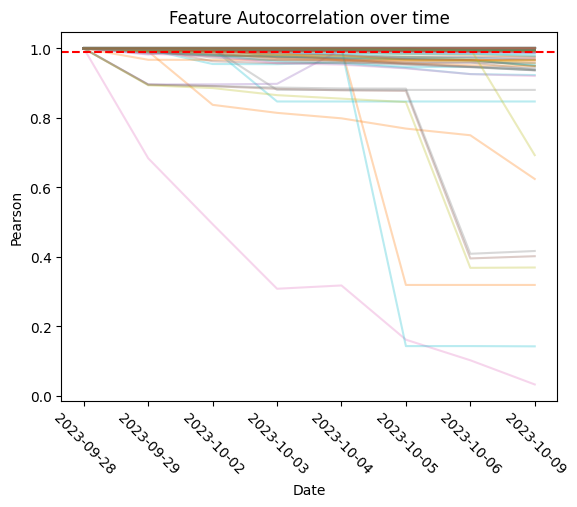

In [10]:
import matplotlib.pyplot as plt
corr_df = pd.DataFrame(corr_cols)
corr_df.plot(legend=None, alpha = 0.3)
plt.axhline(y = .99, color = "r", linestyle = "dashed")
plt.title("Feature Autocorrelation over time")
plt.xticks(ticks = [i for i in range(len(all_dates))], labels = all_dates, rotation = -45)
plt.xlabel("Date")
plt.ylabel("Pearson")

In [11]:
long_term_columns = corr_df.columns[(corr_df.min() > 0.99)]
short_term_columns = corr_df.columns[(corr_df.min() <= 0.99)]

In [17]:
corr_df.min().sort_values()

last_price_vs_sma_10d        0.033063
pb_ratio                     0.142733
debt_eq                      0.319424
last_price_vs_sma_50d        0.368646
last_price_vs_sma_100d       0.395764
                               ...   
ebitda_margin                1.000000
net_margin                   1.000000
revenue_per_share            1.000000
diluted_eps_growth_avg_5y    1.000000
price_close_ytd              1.000000
Length: 264, dtype: float64

In [12]:
short_term_columns.shape

(36,)

In [19]:
filtered_df["pb_ratio"].isna().sum()

665

Interestingly, there are many many highly auto-correlated features. I think we can think of it like a division into 2 tasks:

1. good long-term return stocks with auto-correlated features (ex: long-term features)
2. short term fluctuations with not as auto-correlated features (ex: short-term features)